### Import libraries

In [ ]:
## Import libraries

import os
import pandas as pd
from datetime import date, datetime
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import chi2, uniform, randint
import sys
import seaborn as sns
import joblib
import logging as log
import json

## scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve

## xgboost
import xgboost as xgb

### Custom functions (local)

from ml_functions.ml_builder import TrainTestSplit, XGBParam, eda_plot, sqrt_neg, create_default_transformer, create_xgb_model, xgb_random_optimize, xgb_random_feature_selection
from ml_functions.data_exploration import plot_kmeans_inertia, KMeansHandler, rfe_numeric_feature_selection

from ml_functions.ml_evaluation import cutoff_table, convert_date, var_parser, plot_roc_and_precision_recall, confusion_matrix_report, backward_elimination_model, plot_model_coef, get_null_columns, impute, create_histogram, create_boxplot, eda_plot, eda_plot_all

### Set up connections and variables

In [ ]:
# configure logging
log.basicConfig(level=log.INFO)

RANDOM_SEED = 123

### Get data and configuration

Note that the configuration file will be loaded again later. The configs here are just for data processing, not model-building

In [ ]:
### Get data here
# Data used to create this script can't be shared publicly
# TODO: Find a new sample data which can be shown

df = pd.read_csv('sample_data.csv')
df_cluster = pd.read_csv('cluster_data.csv')

Graph an elbow graph to determine the appropriate number of clusters/segments.

This isn't really used anymore

In [ ]:
## Sample data not available right now
# TODO: Find a new sample data which can be shown

col_cluster = []

df_plot_inertia = df_cluster[col_cluster]

plot_kmeans_inertia(df_cluster=df_plot_inertia, n_cluster=10, random_seed=RANDOM_SEED)

Create a new cluster. For using an existing cluster, see cell below

In [ ]:
## Create a new cluster

kmeans = KMeansHandler()

kmeans.create_kmeans_cluster(df=df_plot_inertia, n_clusters=5, random_seed=RANDOM_SEED)

cluster_names = {
    0: 'col_1',
    1: 'col_2',
    2: 'col_3',
    3: 'col_4',
    4: 'col_5'
    }

kmeans.define_cluster(cluster_names)

# Apply labels
df_cluster = kmeans.apply_cluster(df_cluster)

# merge with df and df_current
df = pd.merge(df, df_cluster[['subscription_id', 'segment']], on='subscription_id', how='left')

# Display the clusters
kmeans.df_cluster_centers

c:\Users\Orvin.Bellamy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,campaigns_usage_perc,kwe_usage_perc,lex_usage_perc,restool_usage_perc,domain_usage_perc,compres_usage_perc
0,0.0021,0.0029,0.0024,0.0191,0.0020,0.0028
1,0.4778,0.3607,0.0777,0.0659,0.0053,0.0126
2,0.8366,0.0800,0.0392,0.0363,0.0033,0.0045
3,0.0958,0.1272,0.7232,0.0415,0.0071,0.0052
4,0.1196,0.7633,0.0630,0.0427,0.0036,0.0079


Use an existing cluster for the training and live (current) data

In [ ]:
## User an existing cluster

# Load the cluster object from local directory
kmeans = joblib.load('models/sample_cluster.pkl')

df_cluster = kmeans.apply_cluster(df_cluster)

df = pd.merge(df, df_cluster[['subscription_id', 'segment']], on='subscription_id', how='left')

In [ ]:
## Sample data not available right now
# TODO: Find a new sample data which can be shown
COL_ANNUAL_USAGE_CATEGORICAL = []

# Change non-numerical data to categorical
# I think we can technically leave them as string/object data type but I like categorical better
for col in COL_ANNUAL_USAGE_CATEGORICAL:
    df[col] = pd.Categorical(df[col])

### RFE Feature Selection

This is a brute force way to shortlist numerical columns that can be a good feature to predict churn.

Note the algorithm assesses the columns in a vacuum, so they may not work well with other features together in a column.

I've stopped using this as it is not that helpful, but good enough to get a sense of which columns have potential. Also doesn't work with categorical columns.

In [ ]:
## Feature Selection RFE for numeric variables

## Sample data not available right now
# TODO: Find a new sample data which can be shown
COL_NOT_NUMERIC = []
COL_RFE_DROP = []

# Set number of columns to return
# i.e. the top 15 columns
num_feature_selection_numeric = 15

# Filter out non-numerical columns
x_numeric = df.drop(COL_NOT_NUMERIC, axis=1)
x_numeric = x_numeric.drop(COL_RFE_DROP, axis=1)

# Set the label
Y_NUMERIC = df['label']

col_best_features = rfe_numeric_feature_selection()

### Building Models

Load configurations and variables. All of these are from JSON files.

So any tuning can be done via the JSON files instead of doing it in the script.

In [ ]:
# with open('config/columns.json', 'r') as f:
#     col_annual_usage = json.load(f)

## Sample data not available right now
# TODO: Find a new sample data which can be shown
COL_FIXED_FEATURES = []
COL_FEATURES = []
COL_NUMERIC_FEATURES_FILTERED = []
LABEL = 'label'
TEST_SIZE = 0.2

RANDOM_SEED = 123
ZERO_OFFSET = 0.1

with open('config/model_config.json', 'r') as f:
    model_config = json.load(f)

xgb_param = model_config['xgb']

Create a XGB model with the predefined parameters. The code to save the model as a .pkl file is somewhere below.

In [ ]:
## Create a XGB model with predefined parameters
xgb_model, df_test = create_xgb_model(
    df=df,
    col_features=COL_FEATURES,
    col_label=LABEL,
    test_size=TEST_SIZE, 
    model_param=xgb_param
)

c:\Users\Orvin.Bellamy\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


rf test score:  0.7736738703339883


Brute force feature selection.

We fix the model parameters, but we randomized the features used. This is a brute force way of finding the best combination of features to user.

Normally we do this first and then the hyperparameter optimization below.

In [ ]:
num_iter = 10  # Number of iterations

df_feature_selection = xgb_random_feature_selection(
    df=df, 
    trial_features=COL_NUMERIC_FEATURES_FILTERED,
    fixed_features=COL_FIXED_FEATURES,
    num_test_features=14,
    label=LABEL,
    model_param=xgb_param,
    random_seed=RANDOM_SEED,
    n_iter=num_iter
)

df_feature_selection

In [ ]:
# Sort based on test score
df_feature_selection.sort_values(by='test_score', ascending=False)
best_index = df_feature_selection.sort_values(by='test_score', ascending=False).iloc[0, 0]

# Show the best features to use
df_feature_selection.loc[df_feature_selection['iter']==best_index, 'numeric_features'].to_list()

Do hyperparameter optimization. Do this when you already know which features you want to use and want to optimize the parameters

Note that it can take a while. 100 iterations is about 20 minutes.

In [ ]:
# set parameters
xgb_param = {
    'xgb__learning_rate': uniform(loc=0.01, scale=0.19),
    'xgb__n_estimators': randint(100, 1000),
    'xgb__subsample': uniform(loc=0.7, scale=0.3),
    'xgb__colsample_bytree': uniform(loc=0.7, scale=0.3),
    'xgb__gamma': uniform(loc=0, scale=0.2),
    'xgb__min_child_weight': randint(1, 10)
}

N_ITER_OPT = 100
CV = 3

# xgb_model is the optimized model
# xgb_param_optimized contains all the optimized parameters
# xgb_random_result lists all the iteration results
# df_test is for evaluation
xgb_model, xgb_random_result, xgb_param_optimized, df_test = xgb_random_optimize(
    df=df,
    col_train=COL_FEATURES,
    col_label=LABEL,
    param=xgb_param,
    test_size=TEST_SIZE,
    random_seed=RANDOM_SEED,
    cv=CV,
    n_iter=N_ITER_OPT
)

Save the model as a .pkl file for future use

In [ ]:
with open('models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

### Model Testing & Evaluation

Load existing models stored as .pkl files. You can directly evaluate old models without needing to recreate them again.

In [ ]:
xgb_model = joblib.load('models/xgb_model.pkl')
kmeans = joblib.load('models/sample_cluster.pkl')

df_train, df_test = train_test_split(df[COL_FEATURES+[LABEL]], test_size=TEST_SIZE, random_state=RANDOM_SEED)

X_train = df_train.drop(columns=LABEL)
y_train = df_train[LABEL]
X_test = df_test.drop(columns=LABEL)
y_test = df_test[LABEL]

Feature importance: list all features and how significant they play a role in the XGB model. The higher the better.

You can replace less significant feature with other features to fine-tune the model.

In [10]:
feature_importance = xgb_model.named_steps['xgb'].feature_importances_

feature_names = xgb_model.named_steps['columntransformer'].get_feature_names_out(input_features=COL_FEATURES)

dir(xgb_model.named_steps['xgb'])

pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

,Feature,Importance
0,numeric__num_users,0.101759
1,numeric__kwe_10_12_perc,0.046560
2,numeric__base_mrr,0.039707
3,numeric__domain_12_6_delta_perc,0.046731
4,numeric__usage_4_6_perc,0.048658
5,numeric__total_addons_mrr_perc,0.050964
6,numeric__lex_7_9_perc,0.045576
7,numeric__campaigns_10_12_perc,0.046359
8,numeric__campaigns_quota85_12,0.045628
9,numeric__num_tickets_12,0.047990


ROC curve: higher AUC means better overall accuracy.

The dots are cutoffs (between 0-1) that rounds the prediction to either 0 or 1.

Higher the cutoff means fewer predictions for 1, hence lower true positive rate. 

It's a trade off between true positiev rate and false positive rate.

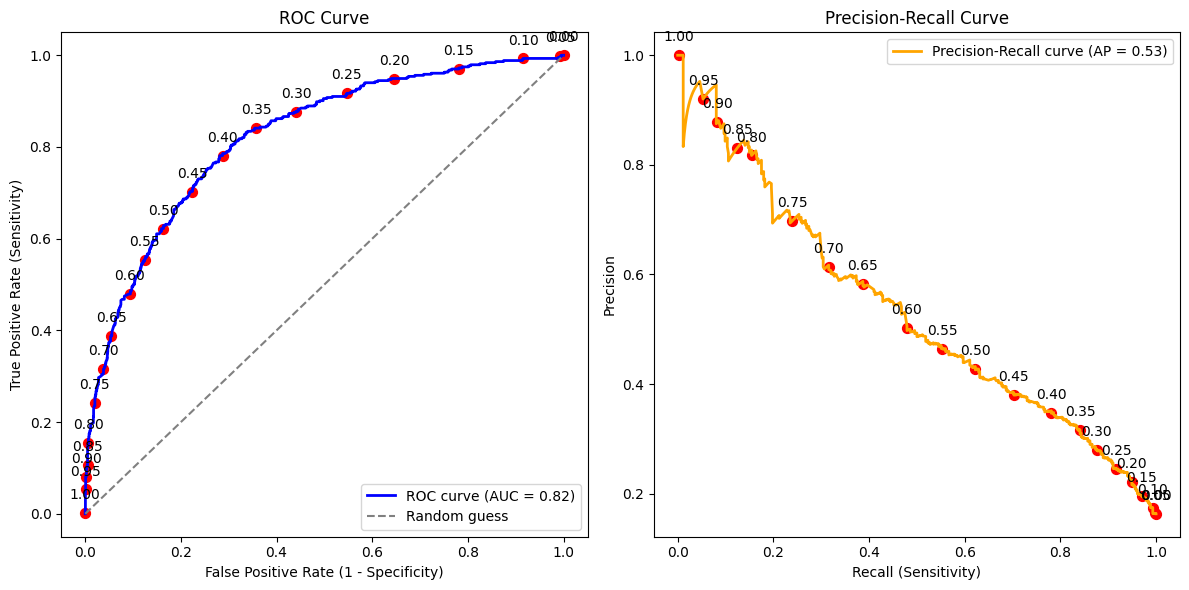

In [69]:
# confusion matrix to visualize the performance of the algorithm.
df_test['prediction'] = xgb_model.predict_proba(df_test)[:, 1]
# df_test['prediction'] = svc.predict_proba(df_test)[:,1]

# Find optimal cutoff (not necessary for the plot)
fpr, tpr, thresholds = roc_curve(df_test['churn'], df_test['prediction'])
opt_idx = np.argmax(tpr - fpr)
opt_cutoff = thresholds[opt_idx]

plot_roc_and_precision_recall(df_test['churn'], df_test['prediction'])

Confusion matrix:


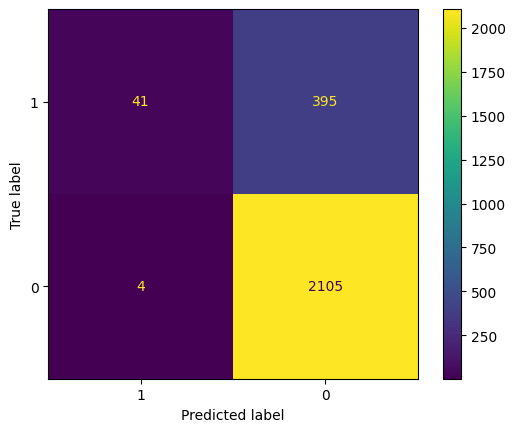

Cutoff:  0.9
Sensitivity: 0.09403669724770643
Specificity: 0.9981033665244191

Accuracy: 0.843222003929273
Precision: 0.9111111111111111
Recall: 0.09403669724770643
F1 score: 0.1704781704781705

Classification report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      2109
           1       0.91      0.09      0.17       436

    accuracy                           0.84      2545
   macro avg       0.88      0.55      0.54      2545
weighted avg       0.85      0.84      0.79      2545



In [11]:
## Confusion matrix

# Tweak the cutoff to compare how the positive rates change
confusion_matrix_report(df=df_test, actual='churn', predicted='prediction', cutoff=0.9)